In [7]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv("completed_flat_price_2017_2023.csv")

### EDA

In [8]:
# converting remaining_lease to int format:
df_cleaned=df

def convert_lease_to_int(lease_str):
    parts = lease_str.split()
    years = int(parts[0])
    return years

df_cleaned['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_int)

# encoding flat_type and storey_range to ordinal data:
labelencoder = LabelEncoder()
df_cleaned['flat_type_encoded'] = labelencoder.fit_transform(df_cleaned['flat_type'])
df_cleaned['storey_range_encoded'] = labelencoder.fit_transform(df_cleaned['storey_range'])


# Adjusted price with inflation
inflation_rate = pd.read_csv('annual_CPI.csv')
inflation_rate = inflation_rate.transpose().reset_index()
inflation_rate.columns = ['Year', 'CPI']
inflation_rate.sort_index(ascending=False, inplace=True)
inflation_rate['Year'] = inflation_rate['Year'].astype(int)
inflation_rate['CPI'] = inflation_rate['CPI'].astype(float)

# Calculate the inflation rate
inflation_rate['Inflation Rate'] = inflation_rate['CPI'].diff() / inflation_rate['CPI'].shift(1) * 100

# Setting the inflation rate for the base year (the first year) to 0%
inflation_rate.iloc[0, inflation_rate.columns.get_loc('Inflation Rate')] = 0
inflation_rate['Cummulative inflation'] = (1+inflation_rate['Inflation Rate']/100).cumprod()

# Add a 'year' column to df2 by converting 'month' to datetime and extracting the year
df_cleaned['year'] = pd.to_datetime(df_cleaned['month']).dt.year

# Merge df2 with the inflation_rate DataFrame on the 'year' column
# Make sure the inflation_rate DataFrame has 'Year' and 'Inflation Rate' columns
df_cleaned = df_cleaned.merge(inflation_rate, left_on='year', right_on='Year', how='left')

# Calculate the adjusted_price
df_cleaned['adjusted_price'] = round(df_cleaned['resale_price'] * (1 + df_cleaned['Inflation Rate'] / 100),2)

# Since we only need the adjusted_price, drop the extra columns
df_cleaned.drop(columns=['Year', 'Inflation Rate', 'year'], inplace=True)

# extracting features:
df2= df_cleaned[['flat_type_encoded', 'storey_range_encoded',
                 'floor_area_sqm', 'remaining_lease_years',
                 'adjusted_price'
                 ]]

df2['adjusted_price'].min()

df2

,flat_type_encoded,storey_range_encoded,floor_area_sqm,remaining_lease_years,adjusted_price
0,1,3,44.0,61,232000.00
1,2,0,67.0,60,250000.00
2,2,0,67.0,62,262000.00
3,2,1,68.0,62,265000.00
4,2,0,67.0,62,265000.00
...,...,...,...,...,...
146867,4,0,127.0,64,733750.12
146868,4,3,122.0,64,733750.12
146869,5,2,181.0,68,1119493.03
146870,5,3,146.0,64,878403.71


### Binning

/var/folders/xz/qc1454j97m3fyrx6gcldlxr40000gn/T/ipykernel_32237/971522541.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price_range'] = pd.cut(df2['adjusted_price'],


price_range
300K-450K    39160
450K-600K    29778
600K-750K    14060
0-300K       11015
750K<         8797
Name: count, dtype: int64

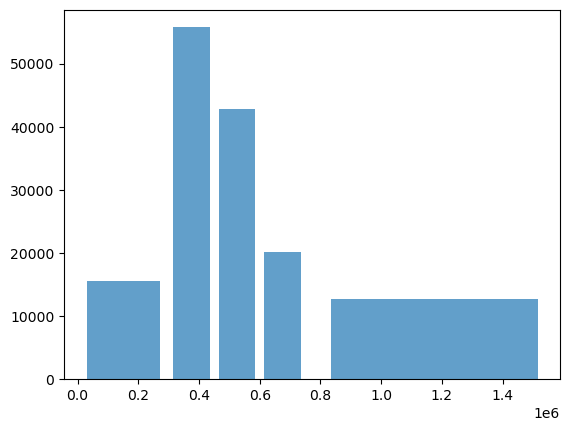

In [9]:

# Binning resale prices into ranges
bins = [0, 300000, 450000, 600000, 750000, 1600000] 
labels = ['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K<']
df2['price_range'] = pd.cut(df2['adjusted_price'], 
                            bins=bins, labels=labels)

plt.hist(df2['adjusted_price'], bins=bins, rwidth=0.8, alpha=0.7)

# Select features and target
X = df2[['floor_area_sqm', 'remaining_lease_years', 
        'storey_range_encoded', 'flat_type_encoded']]
y = df2['price_range']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy,report

y_train.value_counts()

### Decision Tree

Number of nodes in the tree: 63


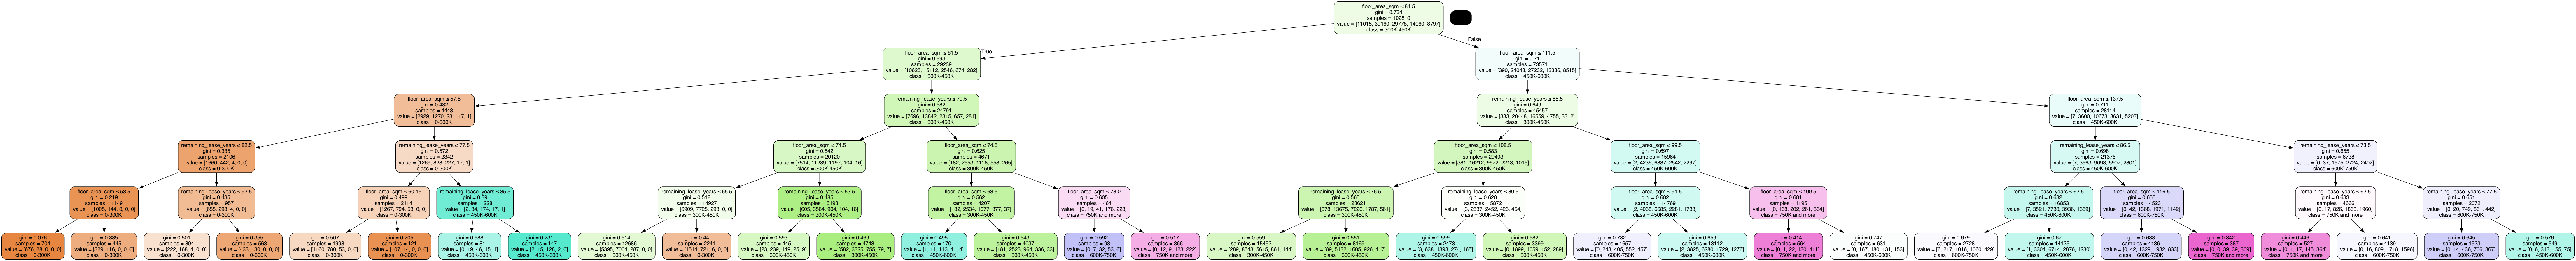

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
from six import StringIO  
from IPython.display import Image


clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42) 

feature_cols = ['floor_area_sqm', 'remaining_lease_years']
X_train_reduced = X_train[feature_cols]

clf.fit(X_train_reduced, y_train)
print('Number of nodes in the tree:', clf.tree_.node_count)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, 
                feature_names=feature_cols,  
                class_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K and more'],
                filled=True, rounded=True,  
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

Number of nodes in the tree: 15


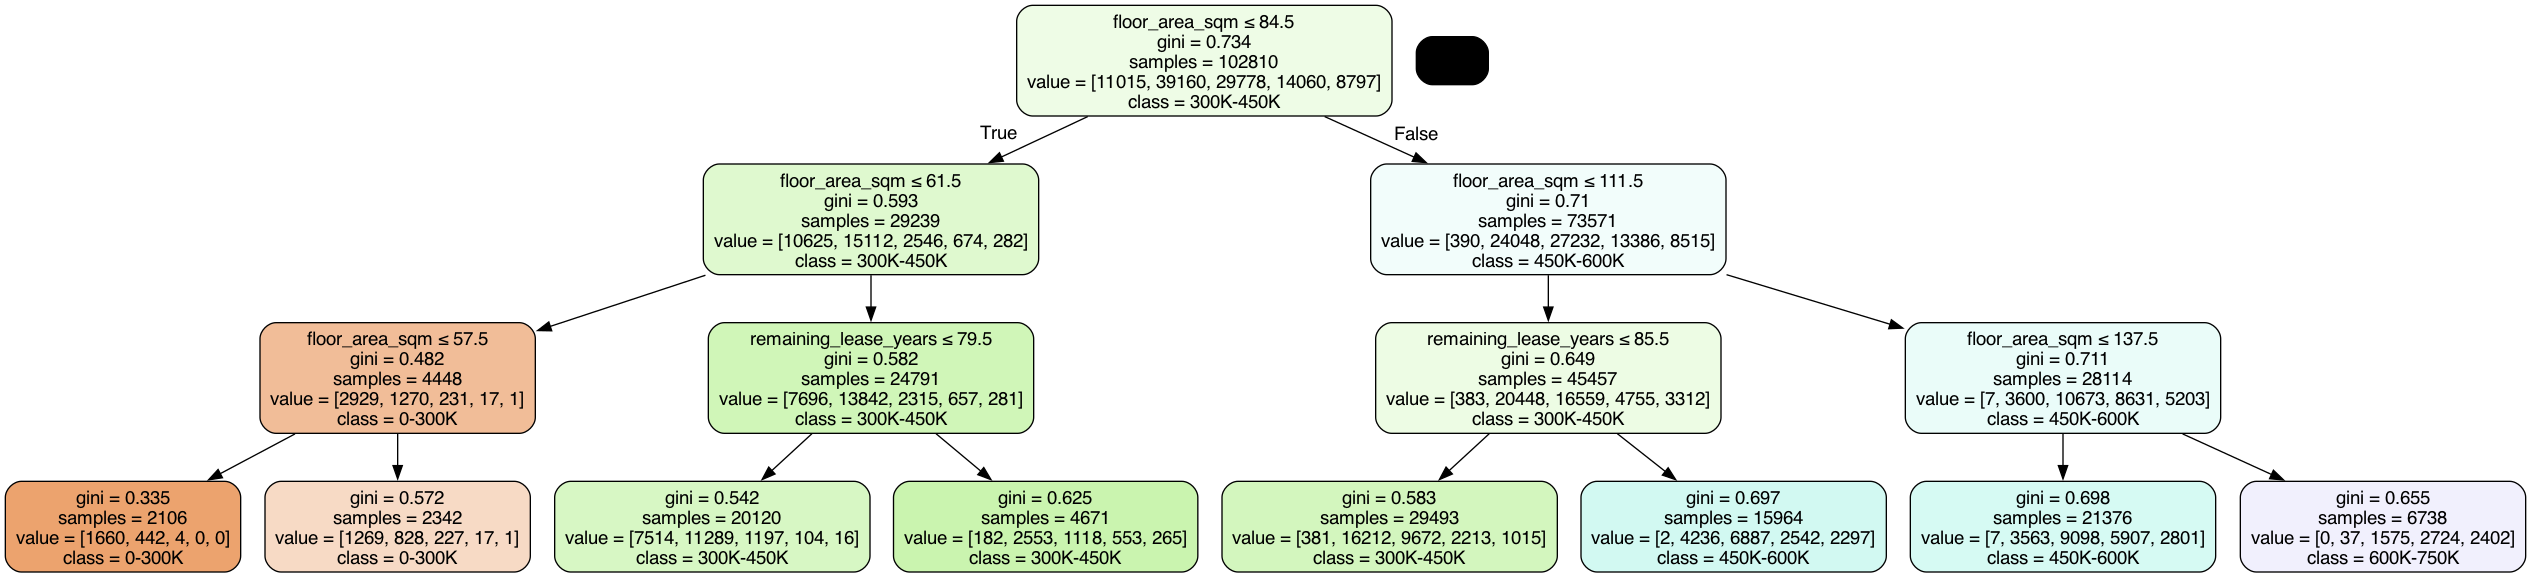

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
from six import StringIO  
from IPython.display import Image


clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42) 

feature_cols = ['floor_area_sqm', 'remaining_lease_years']
X_train_reduced = X_train[feature_cols]

clf.fit(X_train_reduced, y_train)
print('Number of nodes in the tree:', clf.tree_.node_count)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, 
                feature_names=feature_cols,  
                class_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K<'],
                filled=True, rounded=True,  
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [21]:
# catboost on numerical variables:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'X' and 'y' are your features and target variable from your dataset
# And you have already preprocessed and split your data into training and test sets.

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=1000, 
    depth=3, 
    learning_rate=0.01, 
    loss_function='MultiClass',  # Use 'Logloss' for binary classification
    verbose=200,  # To limit the amount of output during training
    random_seed=42
)

# Fit the model
catboost_model.fit(X_train_reduced, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K+'])
print("Classification Report:")
print(report)

0:	learn: 1.6011595	total: 7.44ms	remaining: 7.43s
200:	learn: 1.1268607	total: 1.36s	remaining: 5.4s
400:	learn: 1.0686340	total: 2.54s	remaining: 3.79s
600:	learn: 1.0468587	total: 3.89s	remaining: 2.58s
800:	learn: 1.0344848	total: 5.27s	remaining: 1.31s
999:	learn: 1.0257080	total: 6.62s	remaining: 0us
Model Accuracy: 0.5373564522717988
Classification Report:
              precision    recall  f1-score   support

      0-300K       0.66      0.50      0.57      4780
   300K-450K       0.57      0.74      0.64     16626
   450K-600K       0.47      0.50      0.49     12875
   600K-750K       0.47      0.32      0.38      5957
       750K+       0.66      0.17      0.28      3824

    accuracy                           0.54     44062
   macro avg       0.57      0.45      0.47     44062
weighted avg       0.54      0.54      0.52     44062



Number of nodes in the tree: 15


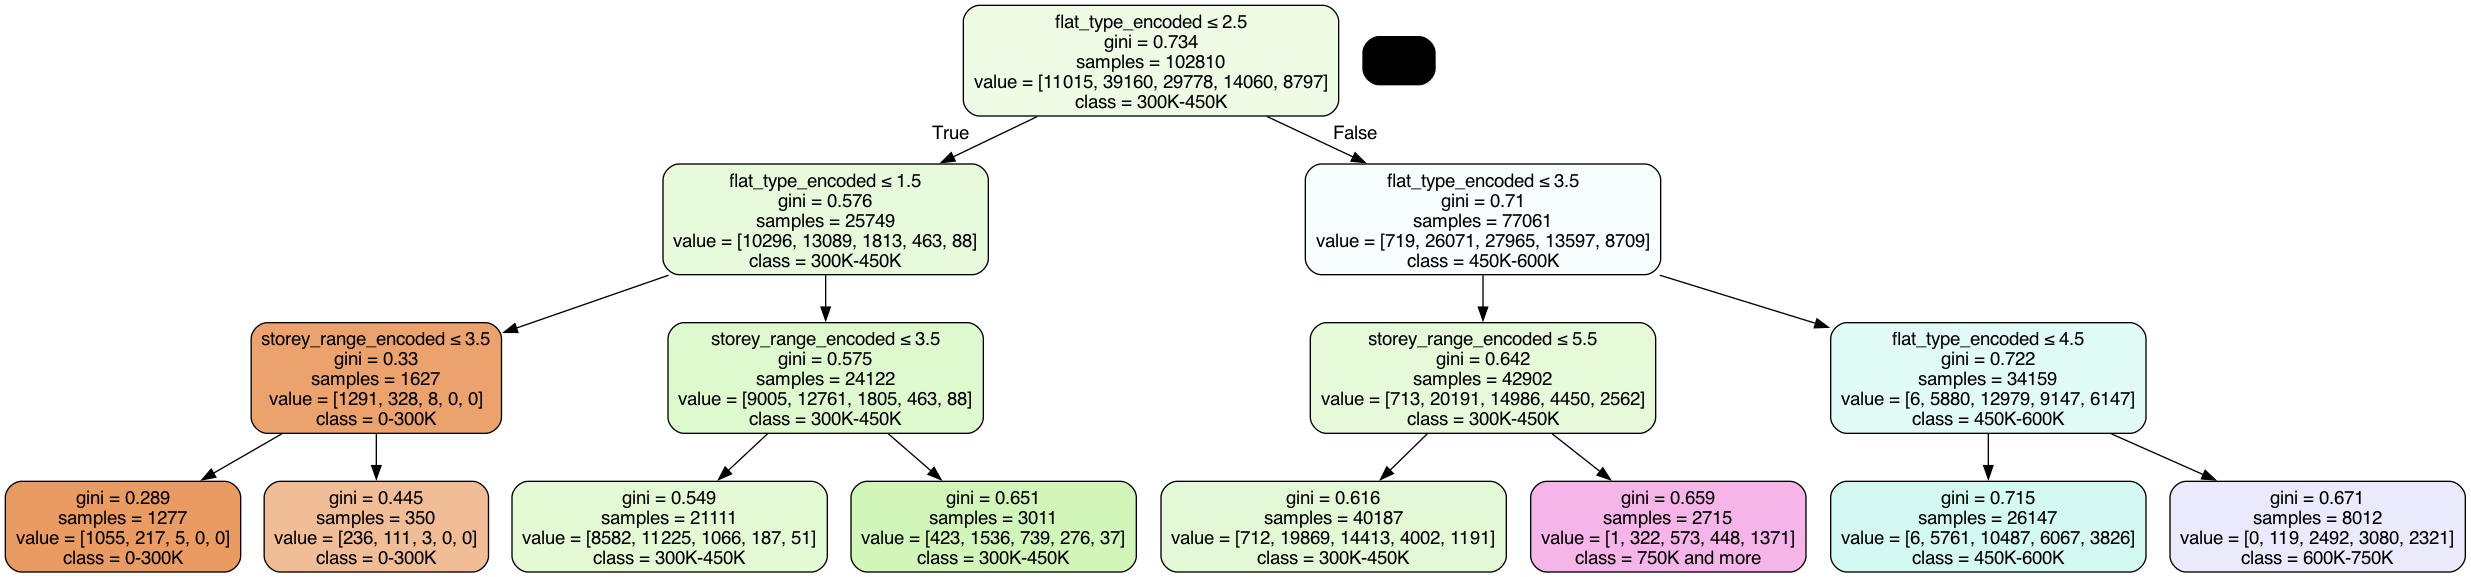

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
from six import StringIO  
from IPython.display import Image


clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42) 

feature_cols = ['flat_type_encoded', 'storey_range_encoded']
X_train_reduced = X_train[feature_cols]

clf.fit(X_train_reduced, y_train)
print('Number of nodes in the tree:', clf.tree_.node_count)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, 
                feature_names=feature_cols,  
                class_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K and more'],
                filled=True, rounded=True,  
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [23]:
# Compare results
X_test_reduced = X_test[feature_cols]
dt_predictions = clf.predict(X_test_reduced)
dt_results_df = pd.DataFrame({'Actual': y_test, 'Predicted': dt_predictions})
dt_results_df

# Accuracy
dt_accuracy = accuracy_score(y_test,dt_predictions)
print("Accuracy:",dt_accuracy)

Accuracy: 0.47487631065317054


#### CatBoost on decision tree (encoded variables)

In [24]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'X' and 'y' are your features and target variable from your dataset
# And you have already preprocessed and split your data into training and test sets.

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=1000, 
    depth=3, 
    learning_rate=0.01, 
    loss_function='MultiClass',  # Use 'Logloss' for binary classification
    verbose=200,  # To limit the amount of output during training
    random_seed=42
)

# Fit the model
catboost_model.fit(X_train_reduced, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K+'])
print("Classification Report:")
print(report)

0:	learn: 1.6013458	total: 11ms	remaining: 11s
200:	learn: 1.1476345	total: 1.58s	remaining: 6.29s
400:	learn: 1.1023400	total: 3.02s	remaining: 4.51s
600:	learn: 1.0933622	total: 4.51s	remaining: 2.99s
800:	learn: 1.0904260	total: 5.99s	remaining: 1.49s
999:	learn: 1.0892775	total: 7.46s	remaining: 0us
Model Accuracy: 0.4940765285279833
Classification Report:
              precision    recall  f1-score   support

      0-300K       0.58      0.33      0.42      4780
   300K-450K       0.53      0.73      0.62     16626
   450K-600K       0.42      0.44      0.43     12875
   600K-750K       0.40      0.23      0.30      5957
       750K+       0.57      0.27      0.36      3824

    accuracy                           0.49     44062
   macro avg       0.50      0.40      0.43     44062
weighted avg       0.49      0.49      0.48     44062



In [79]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict the labels of the test set
y_pred = clf.predict(X_test[feature_cols])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=[str(x) for x in clf.classes_])
print("Classification Report:")
print(report)

# Generate and display a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Accuracy: 0.47
Classification Report:
              precision    recall  f1-score   support

      0-300K       0.78      0.12      0.20      4780
   300K-450K       0.50      0.84      0.63     16626
   450K-600K       0.41      0.35      0.37     12875
   600K-750K       0.40      0.23      0.29      5957
       750K<       0.48      0.16      0.24      3824

    accuracy                           0.47     44062
   macro avg       0.51      0.34      0.35     44062
weighted avg       0.49      0.47      0.43     44062

Confusion Matrix:
[[  550  4229     1     0     0]
 [  153 13918  2359    33   163]
 [    4  7081  4484  1042   264]
 [    0  1808  2564  1372   213]
 [    0   560  1639  1025   600]]


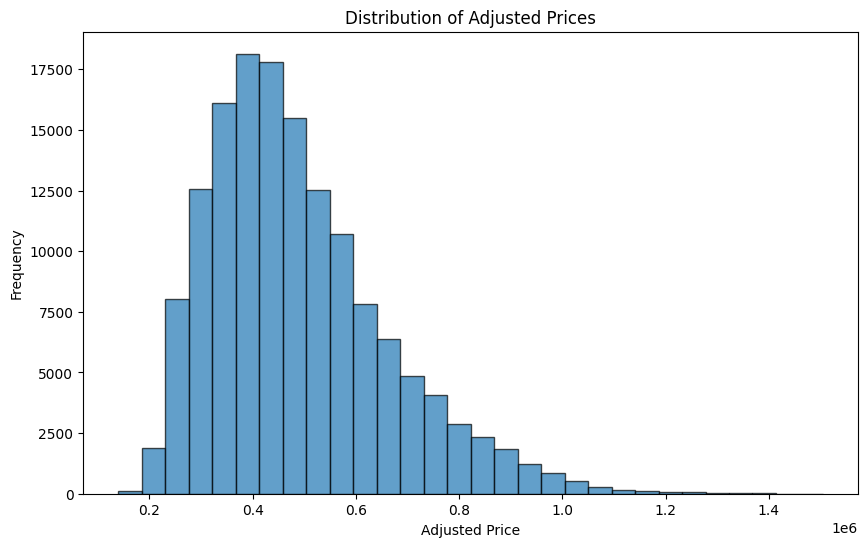

/var/folders/dh/rl06mgxn293dn9_qw9161yh00000gn/T/ipykernel_11450/3132215598.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price_range'] = pd.cut(df2['adjusted_price'], bins=quantile_edges, labels=labels, include_lowest=True)


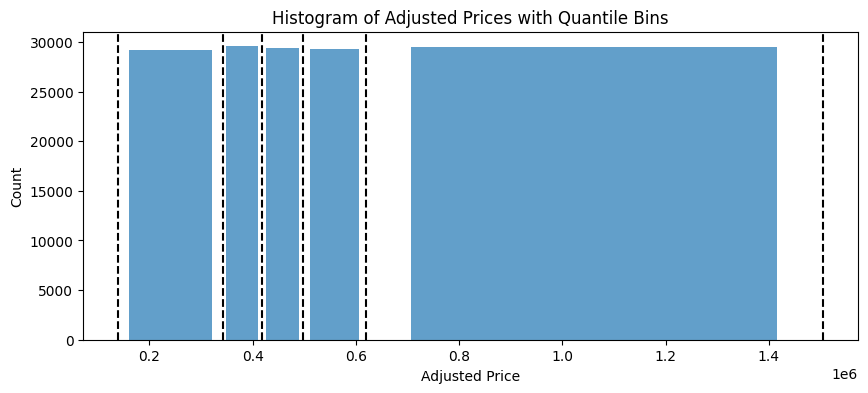

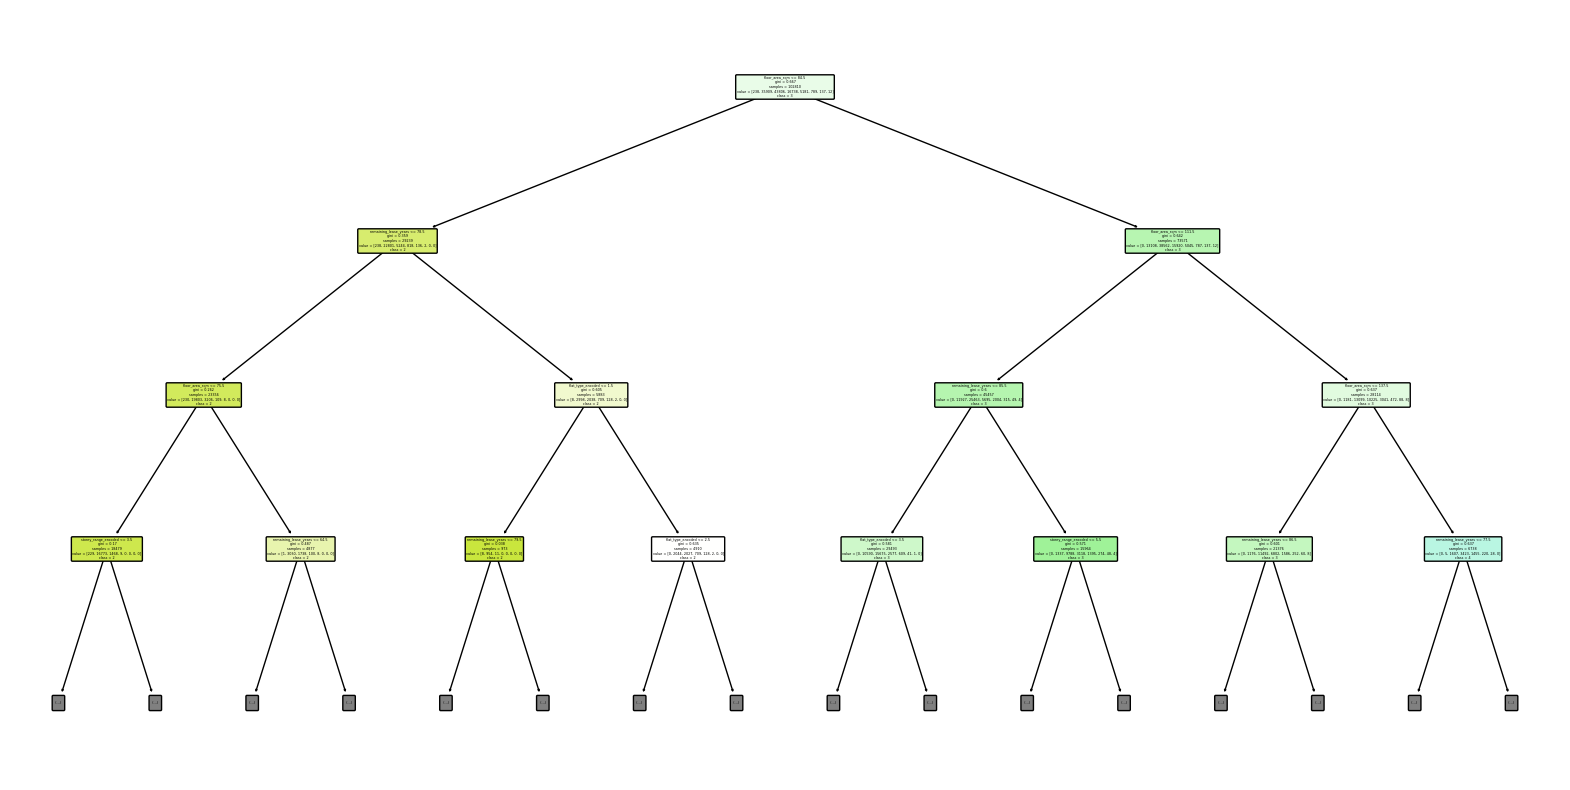

In [52]:
import numpy as np

# Visualize the distribution of adjusted_price
plt.figure(figsize=(10, 6))
plt.hist(df2['adjusted_price'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Adjusted Prices')
plt.xlabel('Adjusted Price')
plt.ylabel('Frequency')
plt.show()

# Determine appropriate bin edges based on the distribution
# For example, using quantiles
quantile_edges = df2['adjusted_price'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
labels = [1, 2, 3, 4, 5]
df2['price_range'] = pd.cut(df2['adjusted_price'], bins=quantile_edges, labels=labels, include_lowest=True)

# Assuming you have already split your dataset into X and y, and trained the classifier 'clf'

# Plot the bins based on quantiles on the histogram
plt.figure(figsize=(10, 4))
for edge in quantile_edges:
    plt.axvline(x=edge, color='k', linestyle='--')
plt.hist(df2['adjusted_price'], bins=quantile_edges, rwidth=0.8, alpha=0.7)
plt.title('Histogram of Adjusted Prices with Quantile Bins')
plt.xlabel('Adjusted Price')
plt.ylabel('Count')
plt.show()

# Convert labels to string type to ensure compatibility with tree.plot_tree
labels_str = [str(label) for label in labels]

# Plot the decision tree with a limited depth for readability
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=X.columns, class_names=labels_str, filled=True, rounded=True, max_depth=3)
plt.show()


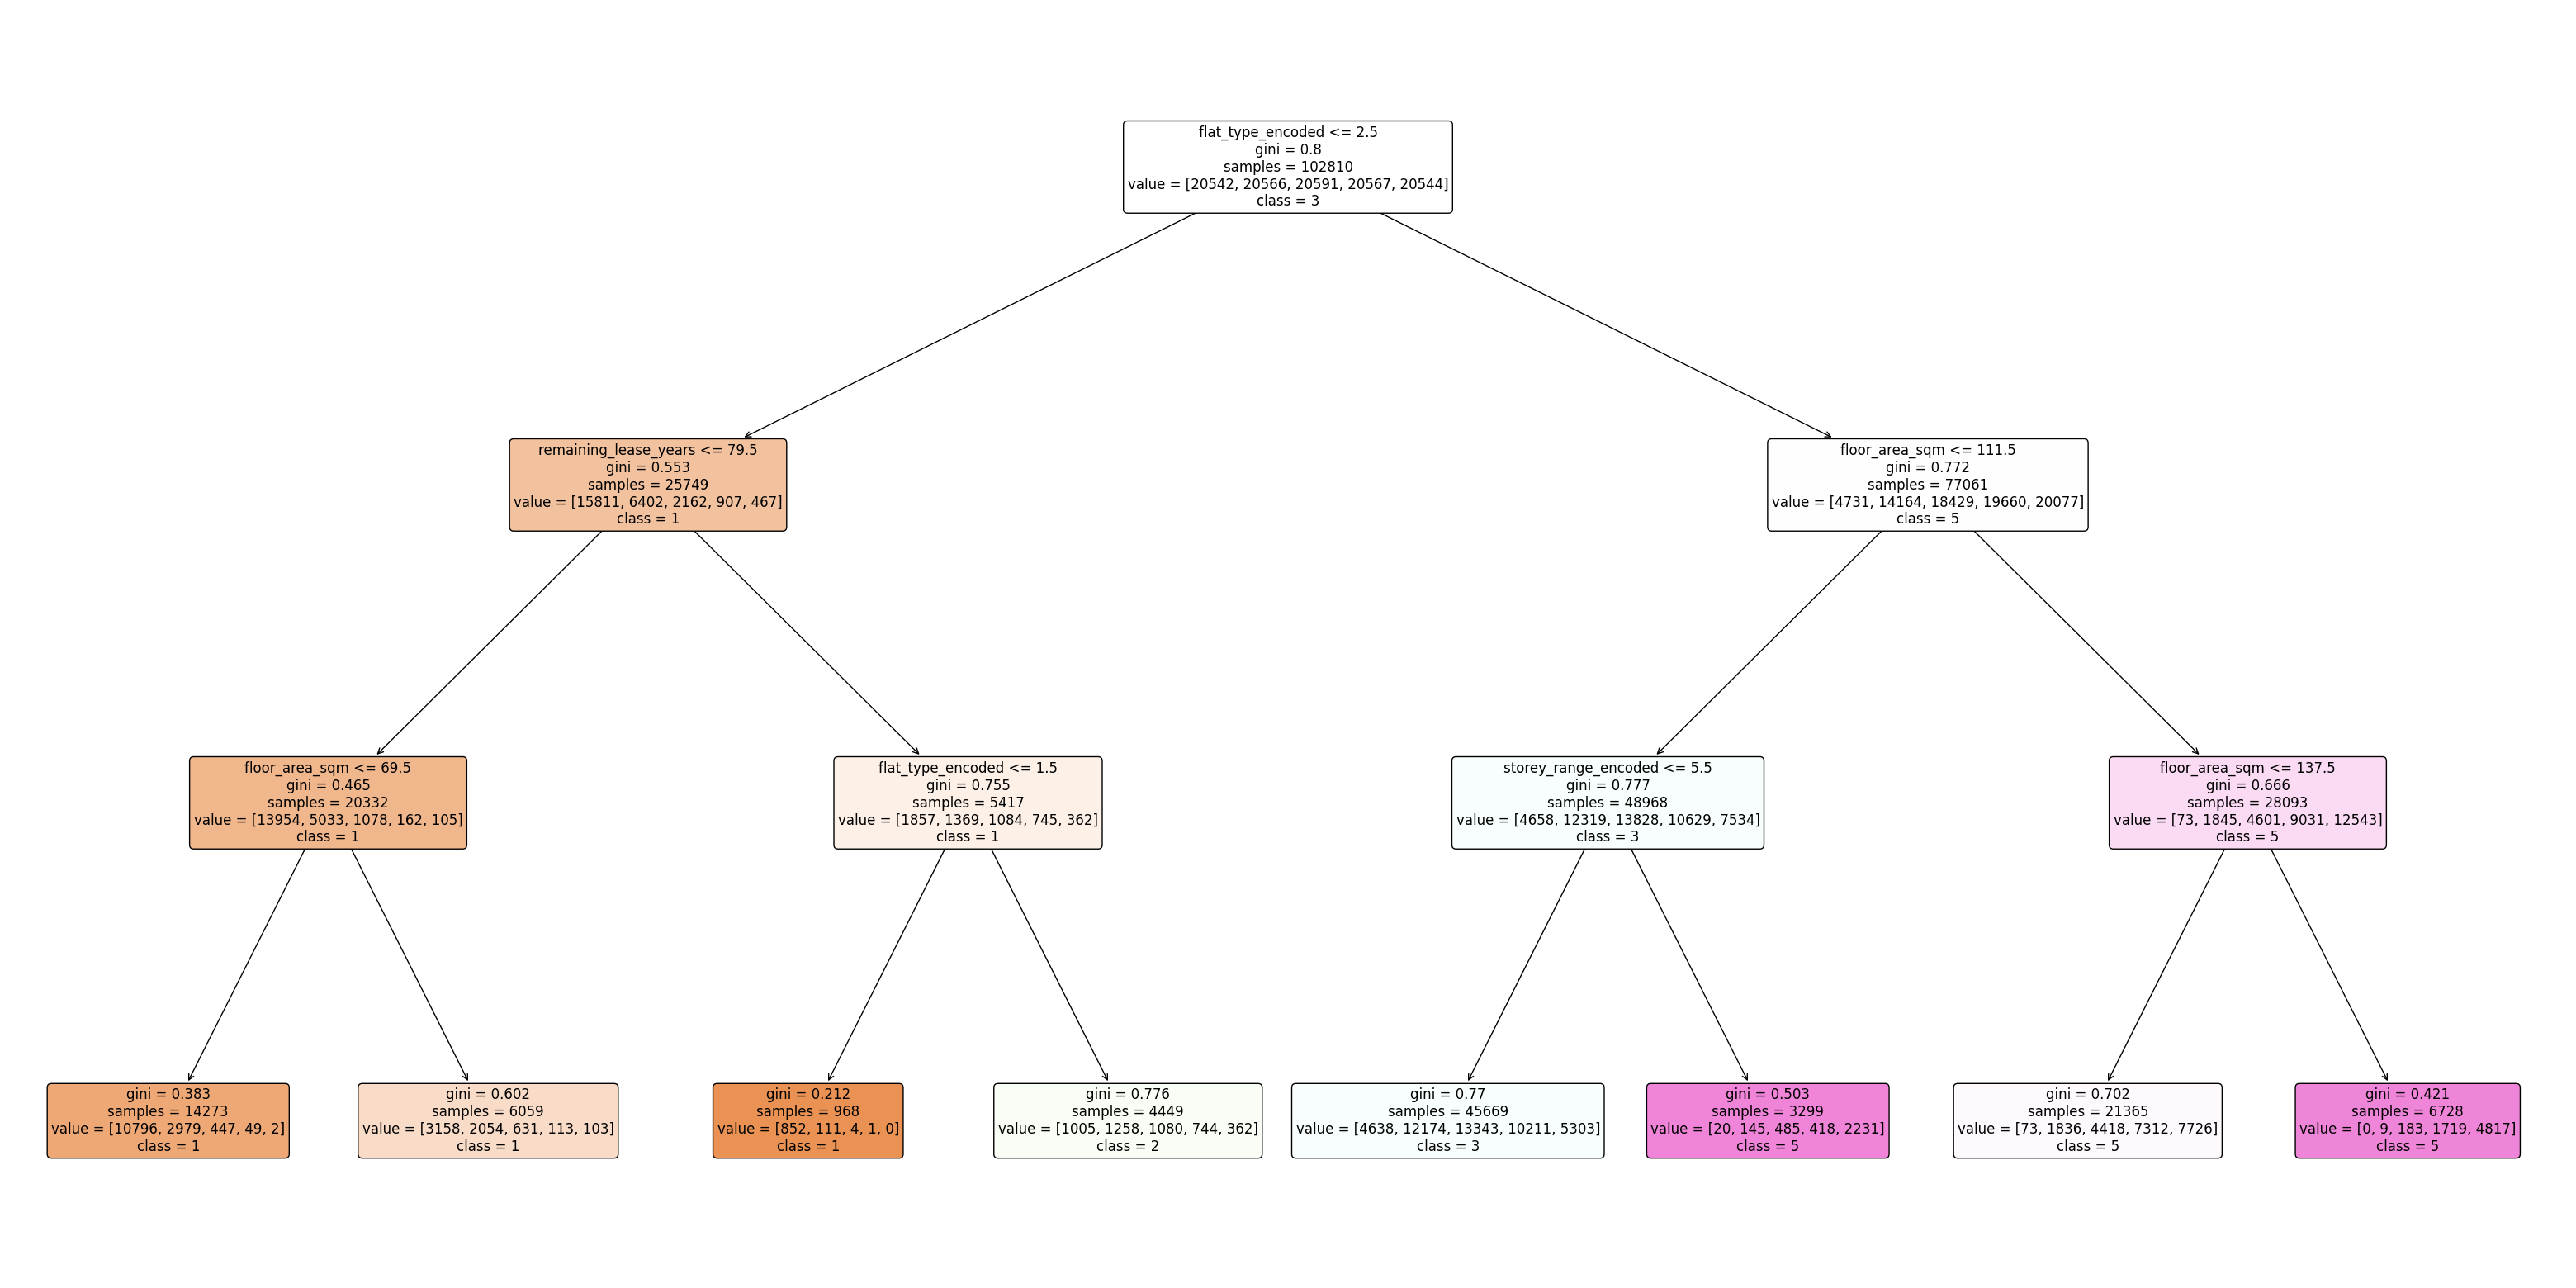

In [55]:
plt.figure(figsize=(40, 20))  # Set an even larger figure size if needed

# Plot the decision tree
decision_tree = tree.plot_tree(
    clf,
    feature_names=X.columns,
    class_names=labels_str,
    filled=True,
    rounded=True,
    fontsize=12  # Try increasing this value
)

# Increase the size of the leaf nodes
for o in decision_tree:
    if 'leaf' in o.get_text():
        o.set_size(20)

plt.show()


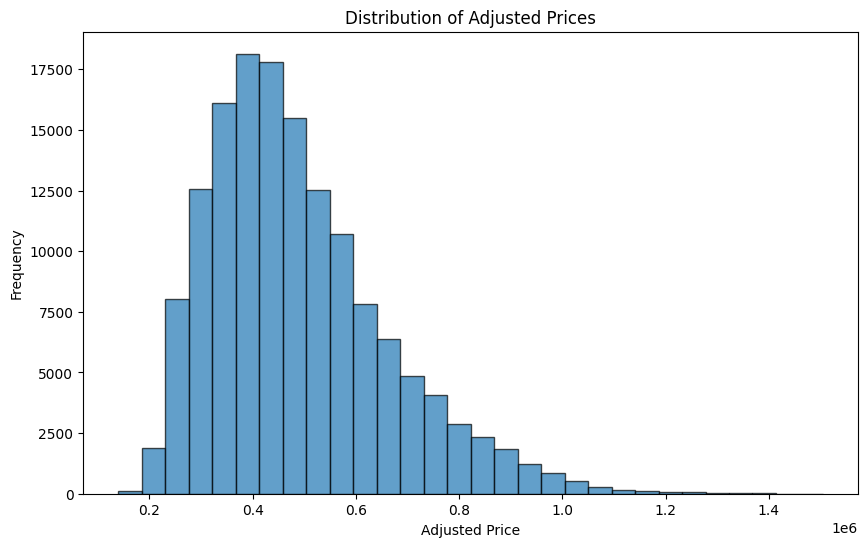

/var/folders/dh/rl06mgxn293dn9_qw9161yh00000gn/T/ipykernel_11450/3080901174.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price_range'] = pd.cut(df2['adjusted_price'], bins=quantile_edges, labels=labels, include_lowest=True)


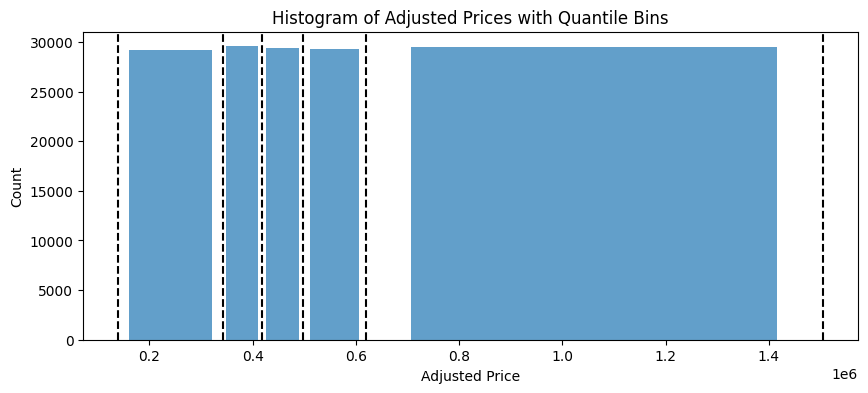

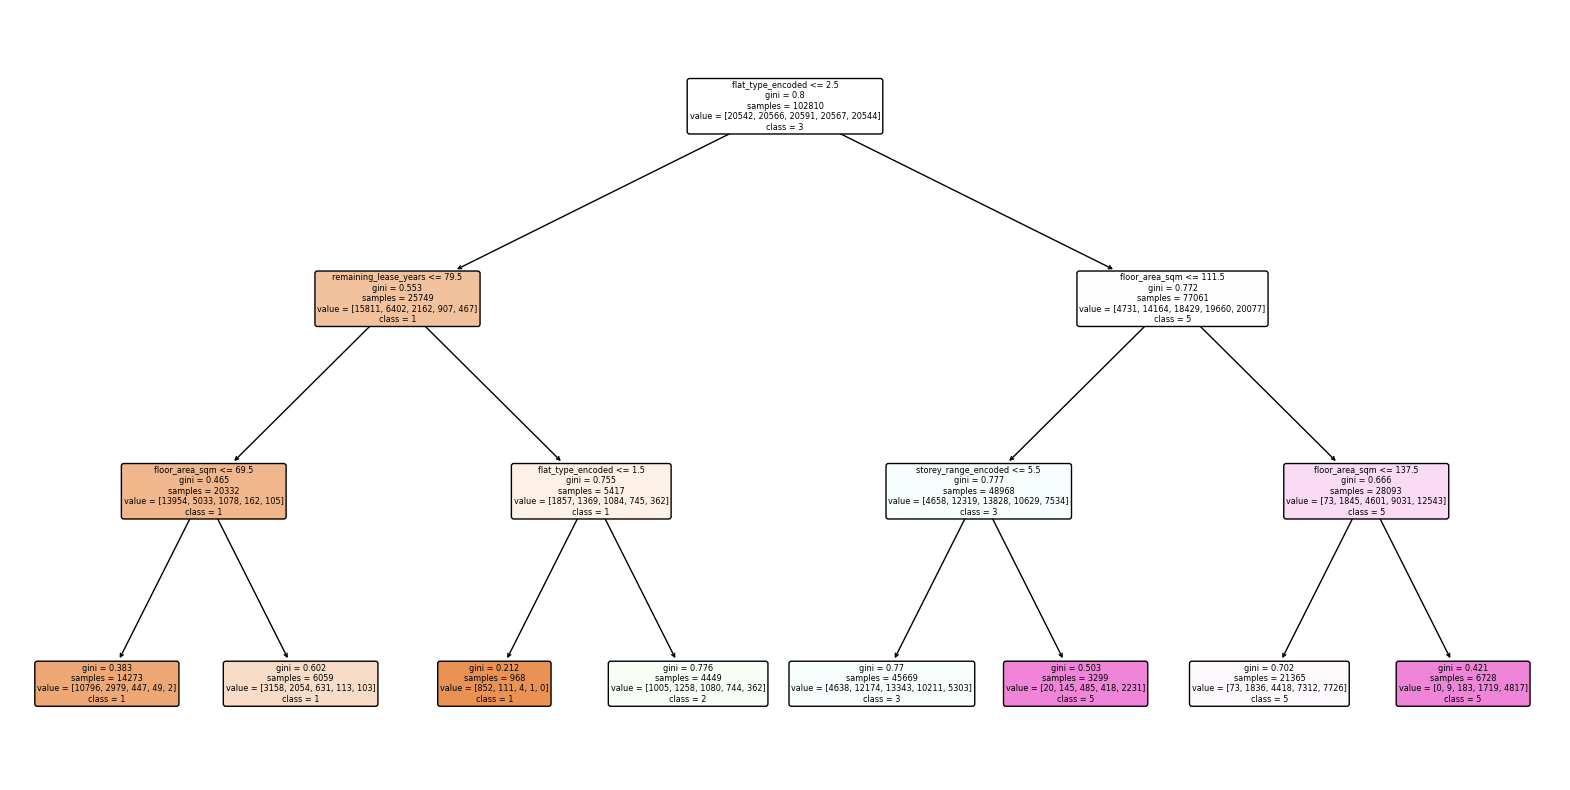

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming `df2` is already loaded in the environment with the appropriate structure.

# Visualize the distribution of adjusted_price
plt.figure(figsize=(10, 6))
plt.hist(df2['adjusted_price'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Adjusted Prices')
plt.xlabel('Adjusted Price')
plt.ylabel('Frequency')
plt.show()

# Determine appropriate bin edges based on the distribution
# For example, using quantiles
quantile_edges = df2['adjusted_price'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
labels = ['1', '2', '3', '4', '5']  # Convert labels to string type directly
df2['price_range'] = pd.cut(df2['adjusted_price'], bins=quantile_edges, labels=labels, include_lowest=True)

# Split the dataset into features and target
X = df2[['flat_type_encoded', 'storey_range_encoded', 'floor_area_sqm', 'remaining_lease_years']]
y = df2['price_range']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train a DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3)  # Limiting the depth of the tree
clf.fit(X_train, y_train)

# Plot the bins based on quantiles on the histogram
plt.figure(figsize=(10, 4))
for edge in quantile_edges:
    plt.axvline(x=edge, color='k', linestyle='--')
plt.hist(df2['adjusted_price'], bins=quantile_edges, rwidth=0.8, alpha=0.7)
plt.title('Histogram of Adjusted Prices with Quantile Bins')
plt.xlabel('Adjusted Price')
plt.ylabel('Count')
plt.show()

# Plot the decision tree with a limited depth for readability
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=X.columns, class_names=labels, filled=True, rounded=True)
plt.show()
